# Data exploration and transformation

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.regression import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

In [2]:
data_file = "Affairs.csv"

df = pd.read_csv(data_file, delimiter=',', 
                 usecols=['affairs','gender','age','yearsmarried','children',
                          'religiousness','education','occupation','rating'],
                 converters={'children': lambda s: True if s == "yes" else False})
df = df.drop(columns=['gender','children'])

display(df.head())
print(df.dtypes)
print("shape: " + str(df.shape))

,affairs,age,yearsmarried,religiousness,education,occupation,rating
0,0,37.000,10.000,3,18,7,4
1,0,27.000,4.000,4,14,6,4
2,0,32.000,15.000,1,12,1,4
3,0,57.000,15.000,5,18,6,5
4,0,22.000,0.750,2,17,6,3


affairs            int64
age              float64
yearsmarried     float64
religiousness      int64
education          int64
occupation         int64
rating             int64
dtype: object
shape: (601, 7)


## 1.1) Look for outliers

In [3]:
numerical_features = df.select_dtypes(exclude = ["object","bool"]).columns
numerical_features = numerical_features.drop("affairs")
print(numerical_features)

Index(['age', 'yearsmarried', 'religiousness', 'education', 'occupation',
       'rating'],
      dtype='object')


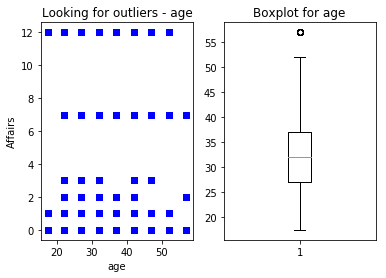

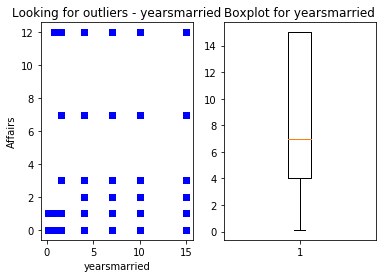

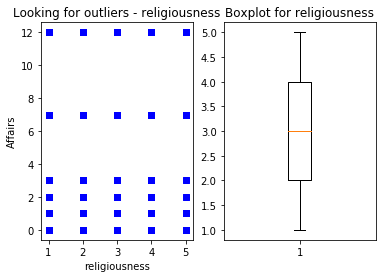

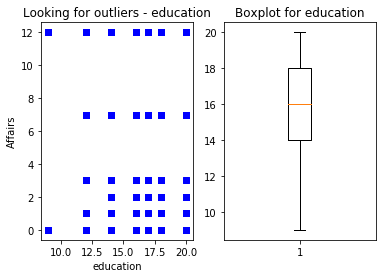

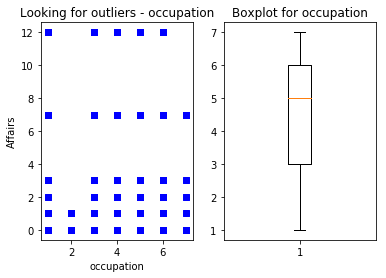

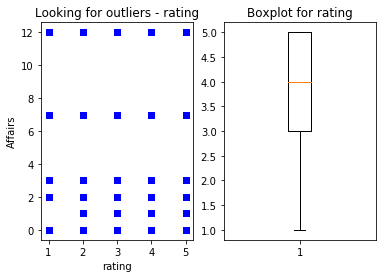

In [4]:
for c in numerical_features:
    plt.subplot(1,2,1)
    plt.scatter(df.loc[:,c], df.affairs, c = "blue", marker = "s")
    plt.title("Looking for outliers - " + c)
    plt.xlabel(c)
    plt.ylabel("Affairs")
    
    plt.subplot(1,2,2)
    plt.title("Boxplot for " + c)
    plt.boxplot(df.loc[:,c])
    plt.show()

In [5]:
# Many numerical values actually indicate a range in which the original value is eg. 22.0 = 20-24
sorted(df.age.unique())

[17.5, 22.0, 27.0, 32.0, 37.0, 42.0, 47.0, 52.0, 57.0]

Create new features:

In [6]:
df["marriageScore"] = df["yearsmarried"] * df["rating"]
df["experienceScore"] = df["age"] * df["education"] * df["occupation"]

Find most important features relative to target

In [7]:
corr = df.corr()
corr.sort_values(["affairs"], ascending = False, inplace = True)
print(corr.affairs)

affairs            1.000
yearsmarried       0.187
age                0.095
experienceScore    0.076
occupation         0.050
marriageScore      0.037
education         -0.002
religiousness     -0.145
rating            -0.280
Name: affairs, dtype: float64


Multiply polynomials top scoring existing features

In [8]:
df["yearsmarried-2"] = df["yearsmarried"] ** 2
df["yearsmarried-3"] = df["yearsmarried"] ** 3
df["yearsmarried-sq"] = np.sqrt(df["yearsmarried"])

df["age-2"] = df["age"] ** 2
df["age-3"] = df["age"] ** 3
df["age-sq"] = np.sqrt(df["age"])

df["experienceScore-2"] = df["experienceScore"] ** 2
df["experienceScore-3"] = df["experienceScore"] ** 3
df["experienceScore-sq"] = np.sqrt(df["experienceScore"])

new_features = ["yearsmarried-2","yearsmarried-3","yearsmarried-sq",
                "age-2","age-3","age-sq",
                "experienceScore-2","experienceScore-3","experienceScore-sq"]

Are there NA values in the numerical features?

In [9]:
print("NAs for numerical features in df : " + str(df[numerical_features].isnull().values.sum()))

NAs for numerical features in df : 0


Log transform of the skewed numerical features to lessen impact of outliers <br />
Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models <br />
As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed

In [10]:
from scipy.stats import skew

#skewness = df.apply(lambda x: skew(x))
#skewness = skewness[abs(skewness) > 0.5]
#print(str(skewness.shape[0]) + " skewed numerical features to log transform")
#skewed_features = skewness.index
#print(skewed_features)
#for sk_f in skewed_features:
#    df[sk_f] = np.log1p(df[sk_f])

In [11]:
numerical_features = df.select_dtypes(exclude = ["object","bool"]).columns
numerical_features = numerical_features.drop("affairs")
print(numerical_features)

Index(['age', 'yearsmarried', 'religiousness', 'education', 'occupation',
       'rating', 'marriageScore', 'experienceScore', 'yearsmarried-2',
       'yearsmarried-3', 'yearsmarried-sq', 'age-2', 'age-3', 'age-sq',
       'experienceScore-2', 'experienceScore-3', 'experienceScore-sq'],
      dtype='object')


# Model

In [12]:
from sklearn.model_selection import train_test_split

df_num = df[numerical_features]
print(df_num.columns)
y = df.affairs

X_train, X_test, y_train, y_test = train_test_split(df_num, y, test_size = 0.5, random_state = 0)
X_train_base, X_test_base, y_train, y_test = train_test_split(df_num.drop(new_features + ["marriageScore","experienceScore"], axis=1), y, test_size = 0.5, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

Index(['age', 'yearsmarried', 'religiousness', 'education', 'occupation',
       'rating', 'marriageScore', 'experienceScore', 'yearsmarried-2',
       'yearsmarried-3', 'yearsmarried-sq', 'age-2', 'age-3', 'age-sq',
       'experienceScore-2', 'experienceScore-3', 'experienceScore-sq'],
      dtype='object')
X_train : (300, 17)
X_test : (301, 17)
y_train : (300,)
y_test : (301,)


In [13]:
from sklearn.preprocessing import StandardScaler
stdScaler = StandardScaler()

X_train = stdScaler.fit_transform(X_train)
X_test = stdScaler.transform(X_test)

C:\Users\Mathias\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Mathias\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Mathias\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [14]:
# Define error measure for official scoring : RMSE
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def my_rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = scorer, cv = 5))
    return rmse

def rms(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))
score_rms = make_scorer(rms, greater_is_better=False)

Perform cross validation on 50% of the data, as they did in the Automatic Statistician report.

In [15]:
from sklearn.metrics.regression import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
from custom_rmse import rmse_cv

score_rms = make_scorer(rmse_cv, greater_is_better=False)

def get_results(ground_truth, prediction):
    r2 = r2_score(ground_truth, prediction)
    mse = mean_squared_error(ground_truth, prediction)
    mae = mean_absolute_error(ground_truth, prediction)
    rmse = sqrt(mean_squared_error(ground_truth, prediction))
    diff_array = np.abs(np.subtract(ground_truth, prediction))
    max_error = np.max(diff_array)
    max_error_index = np.where(diff_array == max_error)[0][0] + 1
    return r2, mse, mae, rmse, max_error, max_error_index

def print_results(ground_truth, prediction):
    r2, mse, mae, rmse, max_error, max_error_index = get_results(ground_truth, prediction)
    allInformation = "r2: " + str(r2)[:6] + " | mse: " + str(mse)[:6] + " | mae: " + str(mae)[:6] + " | rmse: " + str(rmse)[:6] + " | max_error: " + str(max_error)[:6] + " [idx: " + str(max_error_index) + "]"
    print(allInformation)

## 2.2 Ensemble methods

### 2.2.1 Gradient Boosting Method

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
            'learning_rate': [0.02, 0.1, 0.2],
            'n_estimators': [100, 250, 750, 900, 1500],
            'min_samples_split': [2, 5, 9, 20, 30, 45],
            'min_weight_fraction_leaf': [0, 0.25, 0.5],
            'max_depth': [3, 4, 7, 9, None],
            'min_impurity_decrease': [0, 1e-7]
             }

regressor = GradientBoostingRegressor()
reg_gscv = GridSearchCV(regressor, param_grid, cv=5, scoring=score_rms, n_jobs=-1, verbose=5)
reg_gscv.fit(X_train, y_train)
regressor = GradientBoostingRegressor(**reg_gscv.best_params_)

# Look at predictions on training and validation set
print("RMSE on Training set :", my_rmse_cv(regressor, X_train, y_train).mean())
print("RMSE on Training set (base) :", my_rmse_cv(regressor, X_train_base, y_train).mean())
print("RMSE on Test set :", my_rmse_cv(regressor, X_test, y_test).mean())
print("RMSE on Test set (base) :", my_rmse_cv(regressor, X_test_base, y_test).mean())

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 342 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 702 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 1206 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1854 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2646 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3096 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3582 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4104 tasks      | ela

RMSE on Training set : 3.729994093730794
RMSE on Training set (base) : 3.7135856062017765
RMSE on Test set : 3.6675672081307105
RMSE on Test set (base) : 3.419901572052494


In [33]:
regressor.fit(X_train, y_train)
test_prediction = regressor.predict(X_test)
print_results(y_test, test_prediction)

r2: -0.323 | mse: 13.891 | mae: 2.2606 | rmse: 3.7271 | max_error: 12.331 [idx: 123]


### 2.2.2 Random Forest

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
            'n_estimators': [100, 250, 750, 900, 1500],
            'min_samples_split': [2, 5, 9, 20, 30, 45],
            'min_weight_fraction_leaf': [0, 0.25, 0.5],
            'max_depth': [3, 4, 7, 9, None],
            'min_impurity_decrease': [0, 1e-7]
             }

regressor = RandomForestRegressor()
reg_gscv = GridSearchCV(regressor, param_grid, cv=5, scoring=score_rms, n_jobs=-1, verbose=5)
reg_gscv.fit(X_train, y_train)
regressor = RandomForestRegressor(**reg_gscv.best_params_)

# Look at predictions on training and validation set
print("RMSE on Training set :", my_rmse_cv(regressor, X_train, y_train).mean())
print("RMSE on Training set (base) :", my_rmse_cv(regressor, X_train_base, y_train).mean())
print("RMSE on Test set :", my_rmse_cv(regressor, X_test, y_test).mean())
print("RMSE on Test set (base) :", my_rmse_cv(regressor, X_test_base, y_test).mean())

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

RMSE on Training set : 3.2530930895356462
RMSE on Training set (base) : 3.199889789264378
RMSE on Test set : 3.216077350614453
RMSE on Test set (base) : 3.173181292788525


In [35]:
regressor.fit(X_train, y_train)
test_prediction = regressor.predict(X_test)
print_results(y_test, test_prediction)

r2: 0.0270 | mse: 10.215 | mae: 2.0051 | rmse: 3.1961 | max_error: 11.868 [idx: 123]


## 2.2 Linear methods

### 2.2.1 Lasso

In [36]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.05, 0.1, 0.2]}

regressor = linear_model.Lasso()
reg_gscv = GridSearchCV(regressor, param_grid, cv=5, scoring=score_rms, n_jobs=-1)
reg_gscv.fit(X_train, y_train)
regressor = linear_model.Lasso(**reg_gscv.best_params_)

# Look at predictions on training and validation set
print("RMSE on Training set :", my_rmse_cv(regressor, X_train, y_train).mean())
print("RMSE on Training set (base) :", my_rmse_cv(regressor, X_train_base, y_train).mean())
print("RMSE on Test set :", my_rmse_cv(regressor, X_test, y_test).mean())
print("RMSE on Test set (base) :", my_rmse_cv(regressor, X_test_base, y_test).mean())

RMSE on Training set : 3.1204470565540565
RMSE on Training set (base) : 3.126343290808294
RMSE on Test set : 3.0763035742738367
RMSE on Test set (base) : 3.0679858647707614


In [37]:
regressor.fit(X_train, y_train)
test_prediction = regressor.predict(X_test)
print_results(y_test, test_prediction)

r2: 0.0875 | mse: 9.5803 | mae: 1.9839 | rmse: 3.0952 | max_error: 11.665 [idx: 12]


### 2.2.2 ElasticNet

In [38]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

param_grid = {'l1_ratio': [0.3,0.5,0.7],
              'alpha': [1.0, 2.0, 5.0],
              'normalize': [True,False],
              'max_iter': [2000]}

regressor = ElasticNet()
reg_gscv = GridSearchCV(regressor, param_grid, cv=5, scoring=score_rms, n_jobs=-1)
reg_gscv.fit(X_train, y_train)
regressor = ElasticNet(**reg_gscv.best_params_)

# Look at predictions on training and validation set
print("RMSE on Training set :", my_rmse_cv(regressor, X_train, y_train).mean())
print("RMSE on Training set (base) :", my_rmse_cv(regressor, X_train_base, y_train).mean())
print("RMSE on Test set :", my_rmse_cv(regressor, X_test, y_test).mean())
print("RMSE on Test set (base) :", my_rmse_cv(regressor, X_test_base, y_test).mean())

RMSE on Training set : 3.1711754399963956
RMSE on Training set (base) : 3.1510994443518694
RMSE on Test set : 3.152658993879162
RMSE on Test set (base) : 3.1013979088143113


In [39]:
regressor.fit(X_train, y_train)
test_prediction = regressor.predict(X_test)
print_results(y_test, test_prediction)

r2: 0.0695 | mse: 9.7686 | mae: 2.0508 | rmse: 3.1254 | max_error: 11.237 [idx: 12]


### 2.2.3 Kernel Ridge

In [40]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

possible_kernels = ["linear","rbf","poly","sigmoid"]

for k in possible_kernels:
    param_grid = []
    if k is not "poly" and k is not "sigmoid":
        param_grid = {'kernel': [k],
                      'alpha': [0.5, 1.0, 2.0, 5.0],
                      'gamma': [0.2,0.5,1.0,2.0]}
    elif k is "poly":
         param_grid = {'kernel': [k],
                      'degree': [2,3,4,5]}
    else:
        param_grid = {'kernel': [k]}

    regressor = KernelRidge()
    reg_gscv = GridSearchCV(regressor, param_grid, cv=5, scoring=score_rms, n_jobs=-1)
    reg_gscv.fit(X_train, y_train)
    print("best params for KernelRidge(" + k + "): " + str(reg_gscv.best_params_))
    regressor = KernelRidge(**reg_gscv.best_params_)
    

    # Look at predictions on training and validation set
    print("RMSE on Training set :", my_rmse_cv(regressor, X_train, y_train).mean())
    print("RMSE on Training set (base) :", my_rmse_cv(regressor, X_train_base, y_train).mean())
    print("RMSE on Test set :", my_rmse_cv(regressor, X_test, y_test).mean())
    print("RMSE on Test set (base) :", my_rmse_cv(regressor, X_test_base, y_test).mean())
    print("\n")

best params for KernelRidge(linear): {'kernel': 'linear', 'alpha': 0.5, 'gamma': 0.2}
RMSE on Training set : 3.467500429098145
RMSE on Training set (base) : 3.1901054413208354
RMSE on Test set : 3.514687896156784
RMSE on Test set (base) : 3.144123215964089


best params for KernelRidge(rbf): {'kernel': 'rbf', 'alpha': 0.5, 'gamma': 2.0}
RMSE on Training set : 3.4105810573966466
RMSE on Training set (base) : 3.4280007266204344
RMSE on Test set : 3.5484916117736134
RMSE on Test set (base) : 3.5478328284359906


best params for KernelRidge(poly): {'kernel': 'poly', 'degree': 2}
RMSE on Training set : 3.158553601513946
RMSE on Training set (base) : 3.203151703941561
RMSE on Test set : 3.1349945921516613
RMSE on Test set (base) : 3.2025776637807937


best params for KernelRidge(sigmoid): {'kernel': 'sigmoid'}
RMSE on Training set : 4.655847436091912
RMSE on Training set (base) : 3.3178803274567117
RMSE on Test set : 27.527218320273164
RMSE on Test set (base) : 3.2163554055423673




### 2.2.4 Support Vector Regression

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("default")

param_grid = {'kernel': ["linear","poly","rbf","sigmoid"],
              'degree': [2,3,4,5],
              'gamma': ['auto','scale'],
              'C': [0.2,0.5,1.0,2.0]}

regressor = SVR()
reg_gscv = GridSearchCV(regressor, param_grid, cv=5, scoring=score_rms, n_jobs=-1)
reg_gscv.fit(X_train, y_train)
regressor = SVR(**reg_gscv.best_params_)
print("best params: " + str(reg_gscv.best_params_))

reg_gscv_base = GridSearchCV(SVR(), param_grid, cv=5, scoring=score_rms, n_jobs=-1)
reg_gscv_base.fit(X_train_base, y_train)
regressor_base = SVR(**reg_gscv_base.best_params_)

# Look at predictions on training and validation set
print("RMSE on Training set :",        my_rmse_cv(regressor,      X_train,      y_train).mean())
print("RMSE on Training set (base) :", my_rmse_cv(regressor_base, X_train_base, y_train).mean())
print("RMSE on Test set :",            my_rmse_cv(regressor,      X_test,       y_test).mean())
print("RMSE on Test set (base) :",     my_rmse_cv(regressor_base, X_test_base,  y_test).mean())